Supervised Learning with pre-labeled datasets

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, IntegerType
from pyspark.ml.feature import Tokenizer
from pyspark.sql import functions as F

# Step 1: Initialize SparkSession

spark = SparkSession.builder \
    .appName("YTSentAnal3") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.master", "local[*]") \
    .getOrCreate()

# Step 2: Define Dataset Paths
file_paths = {
    "LoganPaul": "LoganPaul.csv",
    "OKGO": "OKGO.csv",
    "RoyalWedding": "RoyalWedding.csv",
    "TaylorSwift": "TaylorSwift.csv",
    "Trump": "trump.csv",
}


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/02 15:30:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Load and basic cleaning of data
def load_and_clean(file_path, delimiter=","):
    schema = StructType([
        StructField("label", IntegerType(), True),
        StructField("text", StringType(), True)
    ])
    df = spark.read.option("header", "false").option("sep", delimiter).schema(schema).csv(file_path)
    return df.filter((col("text").isNotNull()) & (col("label").isNotNull()))

# Dataset OKGO was a bit werid
datasets = [load_and_clean(file_path, delimiter=";" if name == "OKGO" else ",") for name, file_path in file_paths.items()]

# Combine all datasets into one DataFrame
combined_df = spark.createDataFrame([], schema=datasets[0].schema)
for df in datasets:
    combined_df = combined_df.union(df)

# Check schema to confirm proper column names
combined_df.printSchema()

root
 |-- label: integer (nullable = true)
 |-- text: string (nullable = true)


### EDA 1: Class Distribution

Seeing if any imbalances exist in the data and if there is a need to apply class weights

Conclusion: Frequency of neutral labeled comments may create bias in the model; weights need to be applied

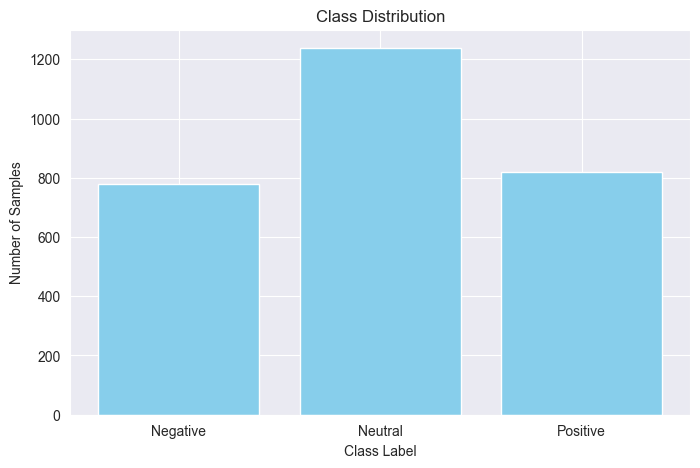

In [4]:
# Class distribution visualization
import pandas as pd
import matplotlib.pyplot as plt

# Extract class distribution
class_distribution = combined_df.groupBy("label").count().toPandas()

# Plot class distribution
plt.figure(figsize=(8, 5))
plt.bar(class_distribution['label'], class_distribution['count'], color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.xticks([-1, 0, 1], ['Negative', 'Neutral', 'Positive'])
plt.show()

### EDA 2.1: Text Length Distribution
Checking if there are any major outliers in terms of comment length in the data which may introduce unnecessary noise.


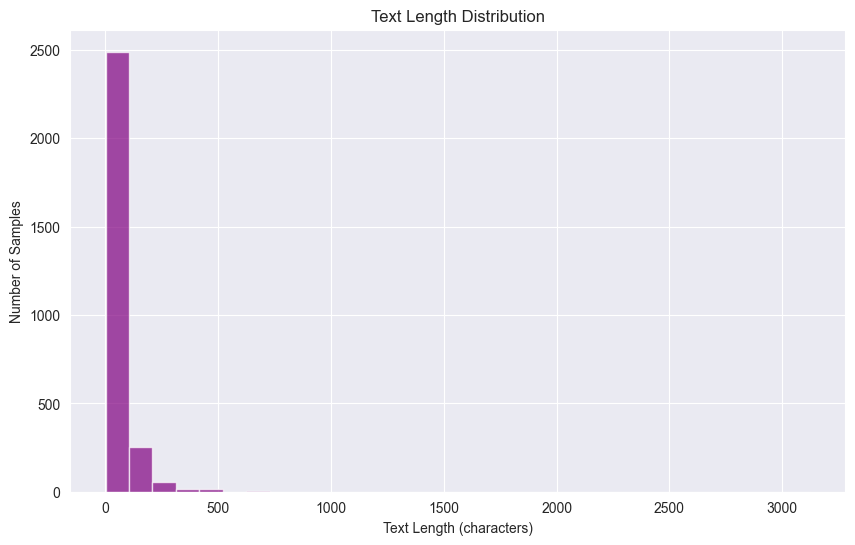

In [5]:
# Add a text length column
text_length_df = combined_df.withColumn("text_length", F.length(F.col("text")))

# Convert to pandas for visualization
text_length_pd = text_length_df.select("text_length").toPandas()

# Plot text length distribution
plt.figure(figsize=(10, 6))
plt.hist(text_length_pd["text_length"], bins=30, color='purple', alpha=0.7)
plt.title('Text Length Distribution')
plt.xlabel('Text Length (characters)')
plt.ylabel('Number of Samples')
plt.show()

### EDA 2.2: Text Length Distribution

We see from the graph above that a majority of the text samples are very short (fewer than 200 characters), but there are a few outliers. Extremely long samples can introduce noise and skew the training process if they are rare or contain unrelated information. We could truncate or filter out excessively large text samples but since this dataset is relatively small it may cause information loss. 

In this case, we check if longer texts show distinct sentiment patterns (e.g., are longer comments more likely to be neutral or positive). If there’s no bias, we can safely keep all samples.

Conclusion: There’s no significant difference in average text length across labels. The variance between the classes is small, with negative comments being slightly longer. Also, long texts are not disproportionately associated with any specific class, meaning they do not introduce bias into the model. Lastly, removing or truncating texts could result in a loss of meaningful data, particularly for negative comments, which have a slightly higher average length.

In [6]:
# Analyze relationship between text length and label
length_label_df = combined_df.withColumn("text_length", F.length(F.col("text"))).select("text_length", "label")
length_label_df.groupBy("label").agg(F.avg("text_length").alias("avg_length")).show()

+-----+------------------+
|label|        avg_length|
+-----+------------------+
|   -1| 67.48717948717949|
|    1|55.844743276283616|
|    0| 58.25848142164782|
+-----+------------------+


### Text Normalization with NLTK

This section tackles more preprocessing of text data, transforming raw text into meaningful tokens. Leveraging NLTK, we remove noise such as special characters, digits, and common stopwords. Additionally, we apply lemmatization to reduce words to their base form, ensuring consistency in representation. The use of PySpark's UDF (User-Defined Functions) enables seamless integration of Python-based transformations into the distributed processing pipeline.

In [7]:
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from pyspark.sql import functions as F


# Download NLTK data
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("stopwords")

# Initialize tools
lemmatizer = WordNetLemmatizer()

# Adjust stopwords to remove domain-specific words
custom_stop_words = {"music", "printer", "song", "paper", }  # Most frequently occuring domain specific words
stop_words = set(stopwords.words("english")) - {"not", "but", "always", "good", "love", "like"}
stop_words.update(custom_stop_words)  # Add custom domain-specific stopwords

# Preprocessing function to remove rare, frequent, and noisy terms
def preprocess_text(tokens):
    processed_tokens = []
    for word in tokens:
        word = word.lower()
        word = re.sub(r'[^\w\s]', '', word)  # Remove special characters
        word = re.sub(r'\d+', '', word)  # Remove digits
        if len(word) > 1 and word not in stop_words:  # Ignore stopwords and single chars
            lemmatized_word = lemmatizer.lemmatize(word)  # Lemmatize word
            processed_tokens.append(lemmatized_word)
    return processed_tokens

preprocess_udf = udf(preprocess_text, ArrayType(StringType()))

# Tokenization
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
tokenized_df = tokenizer.transform(combined_df)

# Apply UDF for normalization and lemmatization
normalized_df = tokenized_df.withColumn(
    "filtered_tokens", preprocess_udf(col("tokens"))
)

# Filter out empty tokenized rows
normalized_df = normalized_df.filter(col("filtered_tokens").isNotNull())
normalized_df = normalized_df.filter(F.size(col("filtered_tokens")) > 0)  # Ensure non-empty token lists


# Select only required columns
refined_preprocessed_df = normalized_df.select("filtered_tokens", "label")

# Verify the updated normalization
refined_preprocessed_df.printSchema()
refined_preprocessed_df.show(5, truncate=False)

[nltk_data] Downloading package wordnet to /Users/ammaar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/ammaar/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ammaar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


root
 |-- filtered_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- label: integer (nullable = true)


+--------------------------------------------------------------------------------------------------------------------------------------+-----+
|filtered_tokens                                                                                                                       |label|
+--------------------------------------------------------------------------------------------------------------------------------------+-----+
|[wow, heard, guy, easily, insecure, douche, ever, seen, youtube, clearly, mental, issue, need, evaluated, give, guy, help, need, asap]|1    |
|[japanese, trying, respectful, lo, gan, but, logan, not, care, wtf]                                                                   |-1   |
|[prick]                                                                                                                               |-1   |
|[think, weed, cry]                                                                                                                    |-1   |

### EDA 3: Token Distribution

Understanding token distributions ensures the vocabulary captures meaningful terms and checks if the normalization and stopword removal preprocessing steps we took above are properly removing unnecessary tokens.

Conclusion: This distribution aligns with the earlier text length analysis. Outliers (texts with many tokens) are rare and do not dominate the dataset. This also confirms the preprocessing steps (normalization and stopword removal) are effectively reducing unnecessary tokens. 

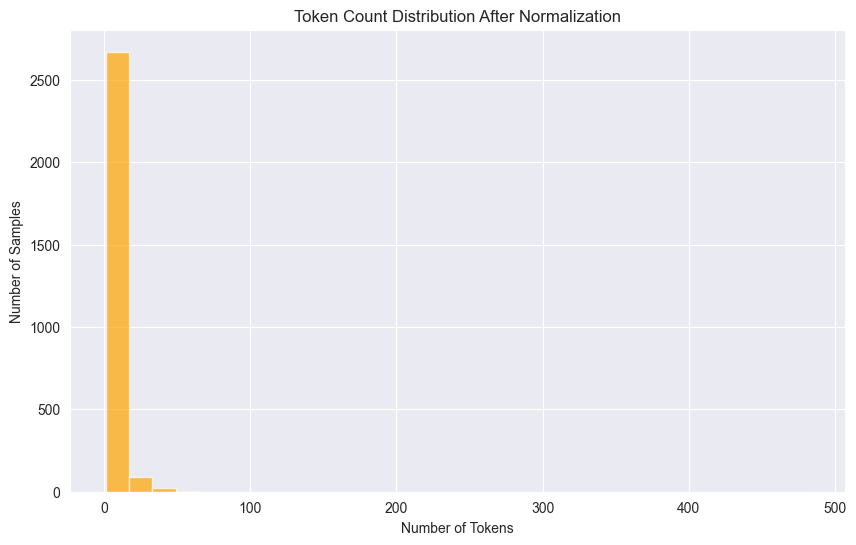

In [8]:
# Token length distribution after normalization
token_count_df = refined_preprocessed_df.withColumn("token_count", F.size(F.col("filtered_tokens")))

# Convert to pandas for visualization
token_count_pd = token_count_df.select("token_count").toPandas()

# Plot token count distribution
plt.figure(figsize=(10, 6))
plt.hist(token_count_pd["token_count"], bins=30, color='orange', alpha=0.7)
plt.title('Token Count Distribution After Normalization')
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Samples')
plt.show()

### EDA 4: Most Common Words (Performed before adjusting the model)

Before we adjusted the stopwords, looking at the graph below, words (“video,” “paper”, "music", "song", "printer", "guy") appear domain-specific and may add noise.

![Most Common Words](EDAImages/MostCommonWords.png)

Prior to any adjustment, we must evaluate each word based on its frequency distribution across the sentiment labels to decide whether it should be removed or retained:

Word: “video”

	•	Counts: Negative (-1): 29, Neutral (0): 32, Positive (1): 81
	•	Observation: “video” is strongly skewed toward positive sentiment.
	•	Decision: Keep.
	•	Its association with positive comments suggests it provides valuable context for sentiment classification.
	
Word: “paper”

	•	Counts: Negative (-1): 28, Neutral (0): 30, Positive (1): 26
	•	Observation: “paper” is somewhat evenly distributed across all labels
	•	Decision: Remove.
	•	As a domain-specific word, “paper” does not contribute meaningfully to sentiment differentiation.
	
Word: “music”

	•	Counts: Negative (-1): 65, Neutral (0): 70, Positive (1): 83
	•	Observation: “Music” is evenly distributed across all labels, with a slight skew toward positive comments.
	•	Decision: Remove.
	•	As a domain-specific word, “music” does not contribute meaningfully to sentiment differentiation.
	
Word: “song”

	•	Counts: Negative (-1): 43, Neutral (0): 59, Positive (1): 65
	•	Observation: Similar to “music,” “song” is evenly distributed and shows no significant label association.
	•	Decision: Remove.
	•	Like “music,” “song” is domain-specific and adds little to sentiment classification.
	
Word: “printer”

	•	Counts: Negative (-1): 30, Neutral (0): 91, Positive (1): 26
	•	Observation: “Printer” is heavily skewed toward neutral comments, with few occurrences in positive or negative contexts.
	•	Decision: Remove.
	•	It appears to be a domain-specific word that is not sentiment-relevant.
	
Word: “guy”

	•	Counts: Negative (-1): 27, Neutral (0): 35, Positive (1): 67
	•	Observation: “Guy” is somewhat skewed toward positive sentiment.
	•	Decision: Keep.
	•	It appears sentiment-relevant, especially in positive contexts (e.g., “this guy is amazing”).

Conclusion: Adjust stopwords to remove domain-specific words "music", "paper", "song", "printer"

### Balancing the Dataset with Class Weights

Since we know these datasets exhibit imbalanced class distributions (-1:780, 0:818, 1: 1238), which can bias the model. We can address this by calculating class weights proportional to their frequencies. These weights are added to the dataset, ensuring fairer representation of each sentiment class during model training. 


In [9]:
# Class Weighting
from pyspark.sql.functions import when

# Add weights to the dataset
class_weights = {
    -1: 1.0 / 780,  
    0: 1.0 / 818,
    1: 1.0 / 1238
}

# Add weights to the dataset
balanced_training_data = refined_preprocessed_df.withColumn(
    "weight",
    when(col("label") == -1, class_weights[-1])
    .when(col("label") == 0, class_weights[0])
    .when(col("label") == 1, class_weights[1])
)

# Verify the added weights
balanced_training_data.groupBy("label").agg({"weight": "avg"}).show()

+-----+--------------------+
|label|         avg(weight)|
+-----+--------------------+
|   -1|0.001282051282051...|
|    1|8.077544426494286E-4|
|    0|0.001222493887530...|
+-----+--------------------+


### Feature Extraction with CountVectorizer and IDF
Next, we transition from raw tokens to numerical feature vectors. Using `CountVectorizer`, we create a vocabulary-based representation of the text, capturing the frequency of terms. The `IDF` (Inverse Document Frequency) scaling step enhances the representation by down-weighting common terms, emphasizing words more indicative of the sentiment. These stages are encapsulated in a pipeline for streamlined preprocessing.

In [10]:
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml import Pipeline

count_vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="raw_features", vocabSize=10000)

# Apply IDF for scaling feature vectors
idf = IDF(inputCol="raw_features", outputCol="features")

# Create a feature extraction pipeline
feature_pipeline = Pipeline(stages=[count_vectorizer, idf])

# Fit and transform the pipeline on the weighted dataset
feature_model = feature_pipeline.fit(balanced_training_data)
featured_df = feature_model.transform(balanced_training_data)

# Select necessary columns for training
final_training_data = featured_df.select("features", "label", "weight")

# Verify the resulting dataset
final_training_data.printSchema()
final_training_data.show(5, truncate=False)

root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)
 |-- weight: double (nullable = true)


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+---------------------+
|features                                                                                                                                                                                                                                                                                                                                                                                         |label|weight               |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Label Remapping

Since PySpark’s MLlib LogisticRegression does not support negative label values and since with is a multiclass classification, we need to remap the labels (-1, 0, 1) to non-negative integers (0, 1, 2). This transformation ensures compatibility with Spark's MLlib while preserving the underlying semantics of the labels.

In [11]:
# Label Remapping and Data Splitting

from pyspark.sql.functions import when

# Remap labels: -1 -> 0, 0 -> 1, 1 -> 2 for ML since -1 cannot b used 4 training
final_training_data = final_training_data.withColumn(
    "label",
    when(col("label") == -1, 0)
    .when(col("label") == 0, 1)
    .when(col("label") == 1, 2)
)


### Training the Logistic Regression Model
The logistic regression model, optimized using k-fold cross-validation. A parameter grid is defined to tune regularization strength (`RegParam`) and the ElasticNet mixing parameter. The cross-validation ensures robust model evaluation across multiple splits, providing the best hyperparameters for the task. Finally, the best model is saved for reuse, with its key parameters displayed.

In [ ]:
# Log regression model training

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define Logistic Regression model with weights
lr = LogisticRegression(featuresCol="features", labelCol="label", weightCol="weight", maxIter=20)

# Define parameter grid for tuning
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Initialize k-fold CrossValidator
cross_validator = CrossValidator(
    estimator=lr,
    estimatorParamMaps=param_grid,
    evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"),
    numFolds=5  # 5-fold cross-validation
)

# Train Logistic Regression with cross-validation
cv_model = cross_validator.fit(final_training_data)

# Extract the best model
best_model = cv_model.bestModel
print(f"Best Model Parameters: RegParam={best_model._java_obj.getRegParam()}, ElasticNetParam={best_model._java_obj.getElasticNetParam()}")

# Save the best model for reuse
best_model.write().overwrite().save("logistic_regression_best_model")

In [19]:
# Evaluate the best model on the entire dataset
test_predictions = best_model.transform(final_training_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
test_accuracy = evaluator.evaluate(test_predictions, {evaluator.metricName: "accuracy"})

print(f"Cross-Validated Test Accuracy: {test_accuracy}")

# Evaluate precision, recall, and F1-score for each class
labels = [0, 1, 2]  
for label in labels:
    precision = evaluator.evaluate(test_predictions, {evaluator.metricName: "precisionByLabel", evaluator.metricLabel: label})
    recall = evaluator.evaluate(test_predictions, {evaluator.metricName: "recallByLabel", evaluator.metricLabel: label})
    f1 = evaluator.evaluate(test_predictions, {evaluator.metricName: "fMeasureByLabel", evaluator.metricLabel: label})
    print(f"Class {label}: Precision = {precision}, Recall = {recall}, F1-Score = {f1}")

Cross-Validated Test Accuracy: 0.9057347670250896


Class 0: Precision = 0.9567039106145251, Recall = 0.8815958815958816, F1-Score = 0.9176155391828533


Class 1: Precision = 0.8419170243204578, Recall = 0.9767634854771784, F1-Score = 0.9043411448328851


Class 2: Precision = 0.9837278106508875, Recall = 0.823019801980198, F1-Score = 0.8962264150943396


/Users/ammaar/SENG550Proj/.venv/lib/python3.12/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


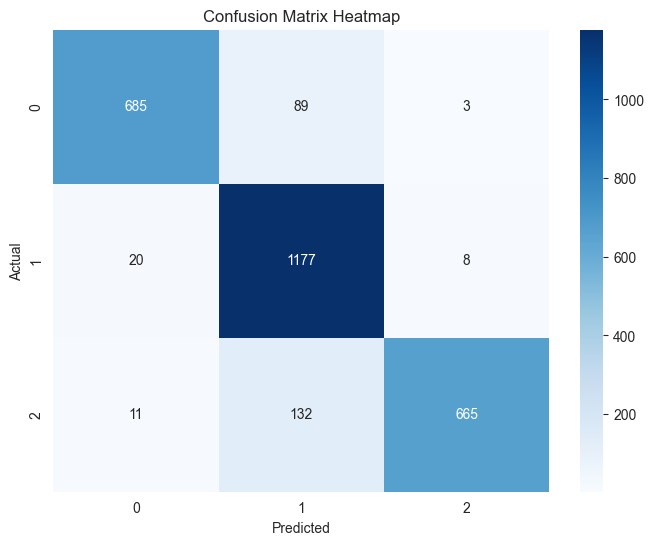

In [21]:
from pyspark.sql.functions import col
from pyspark.mllib.evaluation import MulticlassMetrics

test_predictions = test_predictions.withColumn("label", col("label").cast("float"))
test_predictions = test_predictions.withColumn("prediction", col("prediction").cast("float"))

# Convert predictions to RDD for MulticlassMetrics
prediction_and_labels = test_predictions.select("prediction", "label").rdd.map(tuple)
metrics = MulticlassMetrics(prediction_and_labels)

confusion_matrix = metrics.confusionMatrix().toArray()

# Create confusion matrix heatmap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

labels = [0, 1, 2]  
confusion_df = pd.DataFrame(confusion_matrix, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt=".0f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [15]:
spark.stop()